## 函数

### 基本信息

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr,wilcoxon

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
from time import time
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg

In [3]:
def reshape_topfc(topfc):
    topfc = np.array(topfc)
    n = int(topfc.shape[1]/(n_roi*n_roi))
    topfc = topfc.reshape(n,n_roi,n_roi)
    result = []
    for i in range(topfc.shape[0]):
        result.append(topfc[i][upper_mask])
    return np.array(result)

def fun_get_event_fc(run_label):
    index_ls = []
    all_fc = pd.DataFrame([])
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(Top_fc_path,sub,run_label)))!=0):
            topfc = pd.read_csv(os.path.join(Top_fc_path,sub,run_label,schaefer+'.csv'))
            topfc = pd.DataFrame(reshape_topfc(topfc))
            topfc.index = [f"{sub}_{run_label}" for i in range(topfc.shape[0])]
            all_fc = pd.concat([all_fc,topfc])
    return all_fc

In [4]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    df = pd.concat([data1,data2],axis=1)
    df = df.dropna(axis=0)
    cut_ = int(df.shape[1]/2)
    data = pd.concat([df.iloc[:,:cut_],df.iloc[:,cut_:]])
    return data

In [5]:
bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

Top_fc_path = '/data/dy/TIS_MDD/HAC/Top_fc'
print(f"被试人数：{len(sub_ls)}")

被试人数：31


### 聚类函数

In [6]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def large_matrix_clustering(similarity, labels=None, 
                          cluster_threshold=0.5, 
                          n_clusters=None,
                          method='average'):
    np.fill_diagonal(similarity, 1.0)
    similarity = np.maximum(similarity, similarity.T)
    
    # 距离转换
    distance = 1-similarity
    
    # 转换为压缩格式
    condense = squareform(distance, checks=False)
    del distance,similarity
    
    # 层次聚类
    Z = linkage(condense, method=method, optimal_ordering=True)
    
    # 获取聚类结果,n_cluster和cluster_threshold二选一
    if n_clusters is not None:
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
    else:
        clusters = fcluster(Z, t=cluster_threshold, criterion='distance')

    return clusters

log_path = '/home/duyu/2025/MDD-tTIS/HAC/log-hierarchy.txt'
def write_log(str_,log_path=log_path):
    with open(log_path, 'a') as f:
        f.write(str_)
        f.flush()  # 立即写入磁盘

def fun_robust(similarity,cluster_threshold=0.8,n_clusters=None,if_plot=False):
    time_a = time()  
    write_log(f"当前测试参数：cluster_threshold={cluster_threshold},n_clusters={n_clusters}\n\t")
    
    similarity = np.array(similarity) ## similarity矩阵
    
    clusters = large_matrix_clustering(similarity=similarity,
                                       cluster_threshold=cluster_threshold,
                                      n_clusters = n_clusters)
    
    cluster_counts = Counter(clusters)
    top5 = cluster_counts.most_common(5)
    pattern_n = top5[0][0]
    pattern = np.mean(all_fc[clusters==pattern_n],0)
    for i in range(3):
        write_log(f"第{i+1:d}大Cluster占比 {top5[i][1]/similarity.shape[0]*100:.2f}%\n\t")

    if(if_plot):
        plot_pattern(reconstruct_upper_matrix(pattern))
    write_log(f"用时 {((time()-time_a)/60):.1f}分钟\n")
    return clusters,pattern

### 前后差异分析

In [7]:
import re
def fun_count_pattern_n(df,pattern_n,run_label):
    process = df[df['time'] == run_label]
    subs = [re.split('_',i)[0] for i in process.index]
    result = pd.DataFrame(np.zeros(len(set(subs)))
                          ,columns=['pattern_n'],index=list(set(subs)))
    for sub in subs:
        a = process[process['sub_id'] ==sub]
        n = a[a['pattern_i'] == pattern_n].shape[0]
        result.loc[sub,'pattern_n'] = n
    return result

Event_mask_path = '/data/dy/TIS_MDD/HAC/Event_mask'
bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

def get_event_all(run_label):
    result = []
    index_id = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(Event_mask_path,sub,run_label)))!=0):
            result.append(np.sum(pd.read_csv(os.path.join(Event_mask_path,sub,run_label,f"{schaefer}.csv")),1)[0])
            index_id.append(sub)
    return pd.DataFrame(result,index=index_id,columns=['event_all'])

def regress_age_sex(df,y_cols,x_cols,add_cols=None):
    Y = np.array(df[y_cols]);x = np.array(df[x_cols])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]
    result = pd.DataFrame(Y_resid,index=df.index,columns=y_cols)
    result = pd.concat([result,pd.DataFrame(df[x_cols])],axis=1)
    if(add_cols!=None):
        result = pd.concat([result,pd.DataFrame(df[add_cols])],axis=1)
    return result

### 量表

In [8]:
def fun_match_scale(scale,timepoint):
    result = pd.DataFrame([])
    df = scale.copy()
    process = df[df['condition'] == timepoint]
    for sub in sub_ls:
        if(sub in process.index):
            result = pd.concat([result,process.loc[sub,:]],axis=1)
    return result.T

def fun_scale_change(scale,col_name,after_label):
    df = pd.concat([fun_match_scale(scale,'pre')[col_name],fun_match_scale(scale,after_label)[col_name]],axis=1).dropna(axis=0)
    df.columns = ['baseline','!baseline']
    df = pd.DataFrame(df['!baseline']-df['baseline'],columns=['scale'])
    return df

madrs = pd.read_csv('/data/dy/TIS_MDD/Scales/madrs.csv',index_col='sub') ## MADRS_all
gad7 = pd.read_csv('/data/dy/TIS_MDD/Scales/gad7.csv',index_col='sub') ## GAD7_ALL
hama = pd.read_csv('/data/dy/TIS_MDD/Scales/hama.csv',index_col='sub') ## HAMA_all
hamd = pd.read_csv('/data/dy/TIS_MDD/Scales/hamd.csv',index_col='sub') ## HAMD_all
phq9 = pd.read_csv('/data/dy/TIS_MDD/Scales/phq9.csv',index_col='sub') ## PHQ9_ALL
psqi = pd.read_csv('/data/dy/TIS_MDD/Scales/psqi.csv',index_col='sub') ## PSQI_ALL 只有基线和4周随访
qids = pd.read_csv('/data/dy/TIS_MDD/Scales/qids.csv',index_col='sub') ## QIDS_all
sf36 = pd.read_csv('/data/dy/TIS_MDD/Scales/sf36.csv',index_col='sub') ## SF36_all 只有基线和4周随访
shaps = pd.read_csv('/data/dy/TIS_MDD/Scales/shaps.csv',index_col='sub') ## SHAPS_all 只有基线和4周随访
shaps['condition'] = shaps['target']

scales = {}
scales['MADRS_all'] = madrs;scales['GAD7_ALL']=gad7;scales['HAMA_all']=hama;scales['HAMD_all']=hamd;scales['PHQ9_ALL']=phq9
scales['QIDS_all']=qids

scales_4 = {}
scales_4['MADRS_all'] = madrs;scales_4['GAD7_ALL']=gad7;scales_4['HAMA_all']=hama;scales_4['HAMD_all']=hamd;scales_4['PHQ9_ALL']=phq9
scales_4['QIDS_all']=qids;scales_4['PSQI_ALL']=psqi;scales_4['SF36_all']=sf36;scales_4['SHAPS_all']=shaps

In [9]:
def plot_correlation(after_label):
    process_label = '5th_after'if after_label=='5th' else '4weeks'
    file = scales.copy() if after_label=='5th' else scales_4.copy()
    c_line = '#38a8c5' if after_label=='5th' else '#D62728'
    label = 'D5-post' if after_label=='5th' else 'W4'
    print(f"---Timepoint:{process_label}---")
    for col_name in file.keys(): 
        scale = file[col_name]
        change = fun_scale_change(scale,col_name,after_label)
        x = fun_count_pattern_n(df,pattern_n,'baseline')
        y = fun_count_pattern_n(df,pattern_n,process_label)
        z = pd.DataFrame(y['pattern_n'] - x['pattern_n'],columns=['pattern_n'])
        z = pd.concat([change,z,demo_info],axis=1).dropna(axis=0)
        z['pattern_n'] = np.array(z['pattern_n']).astype(np.float64);z['scale'] = np.array(z['scale']).astype(np.float64)
        partial_corr = pg.partial_corr(data=z,x="pattern_n",y="scale",covar=["age", "sex_id"],method="pearson" )
        rou,p = partial_corr.loc['pearson',['r','p-val']]
        print(f"rou={rou:.3f}, p={p:.3f}, {col_name}")
        if(p<=0.05):
            y =np.array(z['scale']).astype(np.float64);x=np.array(z['pattern_n']).astype(np.float64)
            ## 绘图
            plt.figure(figsize=(6,4))
            sns.regplot(x=x, y=y,ci=95, 
                        scatter_kws={"facecolors": "#262626","edgecolor": "#262626","s": 25},
                        line_kws={"color": c_line})
            ## x,y上下界
            x_max = np.max(x);x_min = np.min(x);x_range=x_max-x_min
            y_max = np.max(y);y_min = np.min(y);y_range=y_max-y_min
            ## 插入相关性注释
            y_text = y_min+y_range*.05;x_text = x_max-x_range*.2
            plt.text(x_text,y_text,f"r={rou:.3f}\np={p:.3f}",ha='left', va='bottom')
            
            plt.xlim(x_min-x_range*.1,x_max+x_range*.1)
            plt.ylim(y_min-y_range*.05,y_max+y_range*.05)
            
            plt.ylabel(f'Δ{col_name[:-4]} (D0→{label})');plt.xlabel('Δ Pattern frequency')

### responder效应分析

In [21]:
import statsmodels.formula.api as smf
import ptitprince as pt

def get_sub_id(run_label):
    index_ls = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(bold_path,sub,run_label)))!=0):
            index_ls.append(sub)
    return index_ls

def get_responder(scale,col_name,time_label,if_print=False):
    run_label = '5th_after' if time_label=='5th' else '4weeks'
    sub_id = get_sub_id(run_label)
    ## 两个时间点的量表
    baseline = pd.DataFrame(fun_match_scale(scale,'pre')[col_name])
    process = pd.DataFrame(fun_match_scale(scale,time_label)[col_name])
    ## 是否respond
    threshold = baseline*0.5
    common_index = process.index.intersection(threshold.index)
    process = process.loc[common_index,:];threshold = threshold.loc[common_index,:]
    responder = process<=threshold
    ## 根据影像数据提取被试
    responder = responder.loc[responder.index.intersection(sub_id),:]
    if if_print:
        print(f"时间节点{time_label}\t{col_name}\n总人数={responder.shape[0]}")
        print(f"\t应答者人数为{np.sum(responder[col_name])}，占比为{(np.sum(responder[col_name])*100/responder.shape[0]):.2f}%")
    responder.columns=['responde']
    return responder

In [22]:
def check_responde_effect(pattern_freq,time_label,scale,col_name):
    res_colors = ['#E6194B','#4363D8']
    
    process_label = '4weeks' if time_label=='4week' else '5th_after'
    c_line = '#38a8c5' if time_label=='5th' else '#cc79f4'
    
    responder = get_responder(scale=scale,col_name=col_name,time_label=time_label)
    responder['responde'] = ['responde' if i else 'non-responde' for i in responder['responde']]
    ## pattern_n change
    a = pattern_freq[pattern_freq['time'] == 'baseline'].loc[responder.index,:]
    b = pattern_freq[pattern_freq['time'] == process_label].loc[responder.index,:]
    b['pattern_n'] -= a['pattern_n']
    ## 量表 change
    scale_change = fun_scale_change(scale,col_name,time_label)
    
    df = pd.concat([b,responder,scale_change],axis=1).dropna(axis=0)
    df['scale'] = df['scale'].astype(np.float32) 
    
    t,p = ttest_ind(df[df['responde']=='responde']['pattern_n'],df[df['responde']!='responde']['pattern_n'])
    result = smf.ols('pattern_n ~ responde + sex + age', data=df).fit();t = result.tvalues[1];p = result.pvalues[1]
    
    title_ = 'D5-post' if time_label=='5th' else 'W4'
    fig, ax = plt.subplots(figsize=(4,4),dpi=300)
    pt.RainCloud(x='responde', y='pattern_n', data=df, order=['responde','non-responde'], palette=res_colors,
                         bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
    y_max = np.max(df['pattern_n']);y_min = np.min(df['pattern_n']);y_range = y_max-y_min
    plt.xlim(-.9,1.5);plt.ylim(y_min-0.1*y_range,y_max+.2*y_range)
    plt.text(0.3,y_max+y_range*0.15,f"T={t:.2f},p={p:.3f}",ha='center',va='center',fontsize=15)
    plt.xticks([-0.3,.9],['responder','non-responder'],rotation=10,fontsize=17)
    plt.title(f"{col_name[:-4]} responde at {title_}",y=1.05)
    plt.xlabel('');plt.ylabel(f"Δ Pattern frequency",fontsize=17)
    plt.show()
    df['scale'] = np.array(df['scale']).astype(np.float32)
    partial_corr = pg.partial_corr(data=df,x="pattern_n",y="scale",covar=["age", "sex_id"],method="pearson" )
    r,p = partial_corr.loc['pearson',['r','p-val']]
    
    if(p<=0.05):
        
        y =np.array(df['scale']).astype(np.float64);x=np.array(df['pattern_n']).astype(np.float64)
        ## 绘图
        ax=plt.figure(figsize=(6,4),dpi=300)
        sns.regplot(x=x, y=y,ci=95, 
                    scatter_kws={"facecolors": "#262626","edgecolor": "#262626","s": 20,'alpha':0},
                    line_kws={"color": c_line})
        plt.scatter(data=df[df['responde']=='responde'],x='pattern_n',y='scale',color=res_colors[0],label='responder',s=30)
        plt.scatter(data=df[df['responde']!='responde'],x='pattern_n',y='scale',color=res_colors[1],label='non-responder',s=30)
        ## x,y上下界
        x_max = np.max(x);x_min = np.min(x);x_range=x_max-x_min
        y_max = np.max(y);y_min = np.min(y);y_range=y_max-y_min
        ## 插入相关性注释
        y_text = y_min+y_range*.05;x_text = x_max-x_range*.2
        plt.text(x_text,y_text,f"r={r:.3f}\np={p:.3f}",ha='left', va='bottom')
        
        plt.xlim(x_min-x_range*.1,x_max+x_range*.1)
        plt.ylim(y_min-y_range*.05,y_max+y_range*.05)
        
        plt.ylabel(f'Δ{col_name[:-4]} (D0→{title_})',fontsize=17);plt.xlabel(f"Δ Pattern frequency",fontsize=17)
        plt.yticks(fontsize=15);plt.xticks(fontsize=15)
        legend = ax.legend(bbox_to_anchor=(.9, 1), loc='upper left', frameon=False,handlelength=0.8,handletextpad=0.3)

### 可视化函数

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from scipy.stats import ttest_rel,wilcoxon

import ptitprince as pt
import statsmodels.formula.api as smf

def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'
def regress_out(df,y_ls,x_ls):
    Y = np.array(df.loc[:,y_ls]);x = np.array(df.loc[:,x_ls])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]

    return pd.DataFrame(Y_resid,index=df.index,columns=y_ls)

def longitudinal_plot(df,value_col,time_order,
                      subj_col = 'sub',time_col='condition',figsize = (10,6),p_values = [],title=None,
                      value_label=None,display_labels=None,palette=None,regress=False,regress_col=None):
    if(display_labels==None):
        display_labels = time_order
    if(value_label==None):
        value_label = value_col
    if(palette == None):
        palette = sns.color_palette("husl", len(time_order))
    if(regress and regress_col==None):
        regress_col = ['age','sex_id']
    ## 开图
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    ## 云雨图
    pt.RainCloud(x=time_col, y=value_col, data=df, order=time_order, palette=palette,
                     bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
    ## 调整边界
    y_max = df[value_col].max()
    y_min = df[value_col].min()
    data_range = y_max - y_min
    step = data_range*.15
    ax.set_ylim(y_min - data_range*0.05,
                y_max + data_range*0.05 + len(time_order)*step)
    ax.set_xlim(-.8,len(time_order)-.7)
    ## 设置标签
    ax.set_xlabel('')
    ax.set_xticklabels(display_labels, fontsize=18)
    ax.set_xticks(range(len(time_order)))
    ax.set_ylabel(value_label,labelpad=10, fontsize=25)
    if(title!=None):
        ax.set_title(title,fontsize=25)
    ## 计算p值
    if(len(p_values) == 0):
        a = df[df['condition']==time_order[0]];a.index=a['sub']
        p_values = np.zeros(len(time_order)-1)
        if(regress):
            formula = f"{value_col} ~ {time_col}"
            for i,col in np.ndenumerate(regress_col):
                formula = f"{formula} + {col}"
        for i in range(1,len(time_order)):
            b = df[df['condition']==time_order[i]];b.index=b['sub']
            valid_index = pd.concat([a,b],axis=1).dropna(axis=0).index.tolist()
            if(regress):
                c = pd.concat([a.loc[valid_index,:],b.loc[valid_index,:]])
                model = smf.mixedlm(formula, data=c, groups=subj_col)
                result = model.fit();p=result.pvalues[1]
            else:
                _,p = ttest_rel(a.loc[valid_index,value_col],b.loc[valid_index,value_col])
            p_values[i-1]=p
    ## 标记显著
    h = data_range * 0.04
    current_y = y_max + data_range*0.05
    for i in range(1,len(time_order)):
        plt.plot([0,0,i,i],[current_y,current_y+h,current_y+h,current_y],lw=1.2, c='k')
        plt.text(i/2, current_y+h, p_star(p_values[i-1]), ha='center', va='bottom', fontsize=15)
        current_y += step
    
    # 同被试连线
    x_pos = {t: i for i, t in enumerate(time_order)}
    for sid, g in df.groupby(subj_col):
        g = g.dropna(subset=[value_col]).sort_values(time_col, key=lambda x: x.map(x_pos))
        if g[time_col].nunique() >= 2:
            xs = [x_pos[t] for t in g[time_col]]
            ys = g[value_col].to_list()
            ax.plot(xs, ys, color='0.7', alpha=0.5, linewidth=1, zorder=1)

In [10]:
def reconstruct_upper_matrix(matrix):
    result = np.zeros((119, 119))
    upper_mask = np.triu(np.ones(result.shape, dtype=bool), k=1)
    result[upper_mask] = matrix
    result = result + result.T
    np.fill_diagonal(result, 0)
    return result

from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

ICN_colors = ['#E6194B','#3CB44B','#FFE119','#4363D8','#F58231','#911EB4','#42D4F4','#F032E6' ]
RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs + ['Sub']
atlas = pd.read_csv('/data/dy/atlas/schaefer100x7_MNI.csv')

order = []
rsn_order = []
for i,rsn in enumerate(RSNs):
    process = atlas[atlas['ICN'] == rsn]
    order += process.index.tolist()
    rsn_order += [i for _ in range(process.shape[0])]
order += [i+100 for i in range(19)]
rsn_order+= [7 for _ in range(19)]

def plot_pattern(patern,width=3,title=None):
    patern = patern[:,order]
    patern = patern.T[:,order]
    size = len(rsn_order)
    fig = plt.figure(figsize=(7, 6),dpi=300)
    gs = GridSpec(2, 2, width_ratios=[5,1],height_ratios=[30, 1], wspace=0.05)
    if(title!=None):
        fig.suptitle(title, fontsize=20,y=.95)
    ax = fig.add_subplot(gs[0,:])
    upper_mask = np.triu(np.ones(patern.shape, dtype=bool), k=1)
    sns.heatmap(patern,cmap='coolwarm',mask=upper_mask)
    for i, icn in enumerate(rsn_order):
        rect = Rectangle((-width, i-0.5),width, 1,fill=True,color=ICN_colors[icn],linewidth=0)
        ax.add_patch(rect)
        rect = Rectangle((i,size),1, width,fill=True,color=ICN_colors[icn],linewidth=0)
        ax.add_patch(rect)
    plt.xlim(-width,size);plt.ylim(size+width,0);plt.xticks([],[]);plt.yticks([],[])
    x = np.arange(len(rsn_order))
    plt.yticks([np.median(x[np.array(rsn_order)==i]) for i in range(len(ICNs))],ICNs,fontsize=15)

## 分析

In [13]:
schaefer = '100'
n_roi = int(schaefer)+19
upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)

### 聚类

In [14]:
all_fc = pd.read_csv(f"/data/dy/TIS_MDD/HAC/Cluster/all_fc/{schaefer}.csv",index_col=0)
similarity = np.array(pd.read_csv(f"/data/dy/TIS_MDD/HAC/Cluster/similarity/{schaefer}.csv"))
similarity_upper_mask = np.triu(np.ones(similarity.shape, dtype=bool), k=1)
print(f"all_fc大小为：{all_fc.shape}\nSimilarity大小为：{similarity.shape}")

all_fc大小为：(5257, 7021)
Similarity大小为：(5257, 5257)


In [15]:
clusters,pattern = fun_robust(similarity=similarity,cluster_threshold=0.91)
cluster_counts = Counter(clusters)
top5 = cluster_counts.most_common(5)

In [16]:
print("\nTop 5 largest clusters:")
for cluster_id, count in top5:
    print(f"Cluster {cluster_id}: 样本量{count}\t占比{(count/all_fc.shape[0]*100):.1f}%")

pattern_n = top5[0][0]
print(f"最大Cluster序号为:{pattern_n}")


Top 5 largest clusters:
Cluster 27: 样本量2502	占比47.6%
Cluster 25: 样本量280	占比5.3%
Cluster 62: 样本量201	占比3.8%
Cluster 32: 样本量194	占比3.7%
Cluster 45: 样本量152	占比2.9%
最大Cluster序号为:27


Text(0.5, 47.59368461099486, 'PC1')

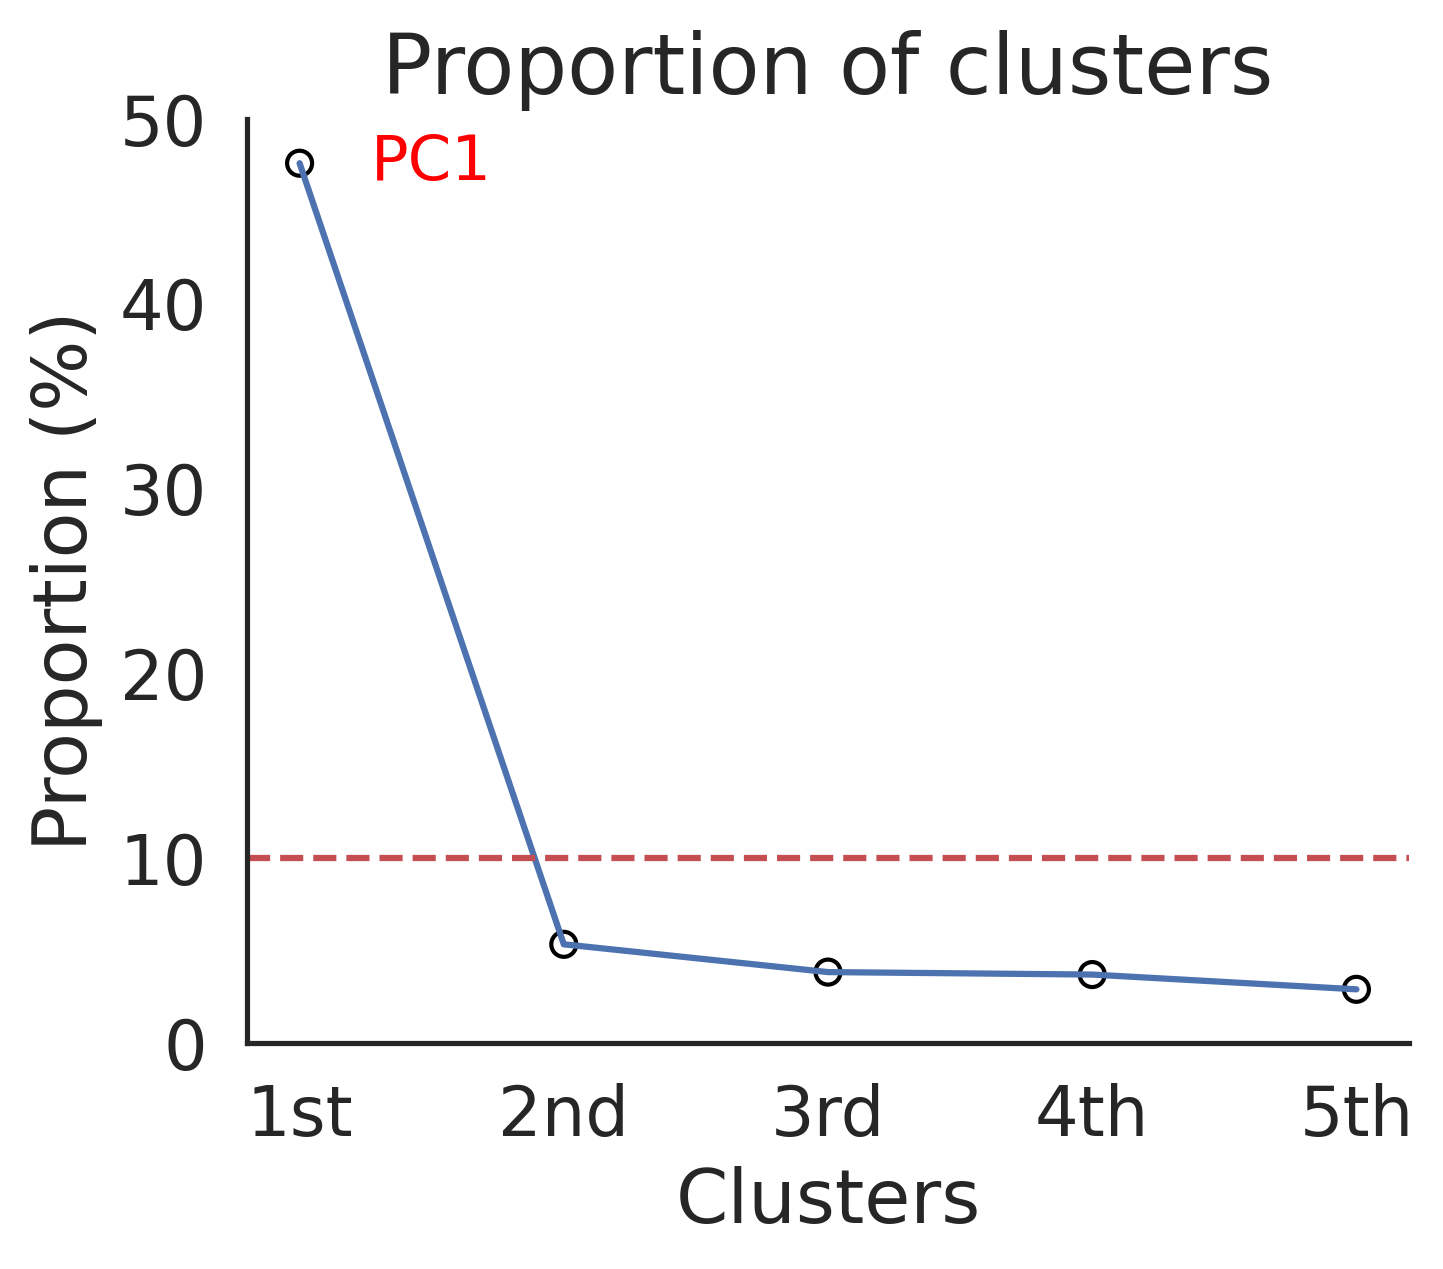

In [17]:
top5 = cluster_counts.most_common(5)
y = np.array(top5)[:,1]*100/len(clusters)
x = np.arange(len(y))
plt.figure(figsize=(5,4),dpi=300)
plt.plot(x,y)

for i in range(len(x)):
    if(y[i]==57.73):
        plt.scatter(x[i], y[i], marker='^',linewidth=2,facecolor='none', color='red')
    else:
        plt.scatter(x[i], y[i], marker='o',linewidth=1,facecolor='none',color='black') 

plt.ylim(0,50)
plt.title('Proportion of clusters',fontsize=20);plt.xlabel('Clusters');plt.ylabel('Proportion (%)')
plt.xticks([i for i in range(5)],['1st','2nd','3rd','4th','5th']);plt.axhline(10,color='r',linestyle='--')
plt.text(0.5,y[0],'PC1',color='red',ha='center',va='center',fontsize=15)

### 聚类质心

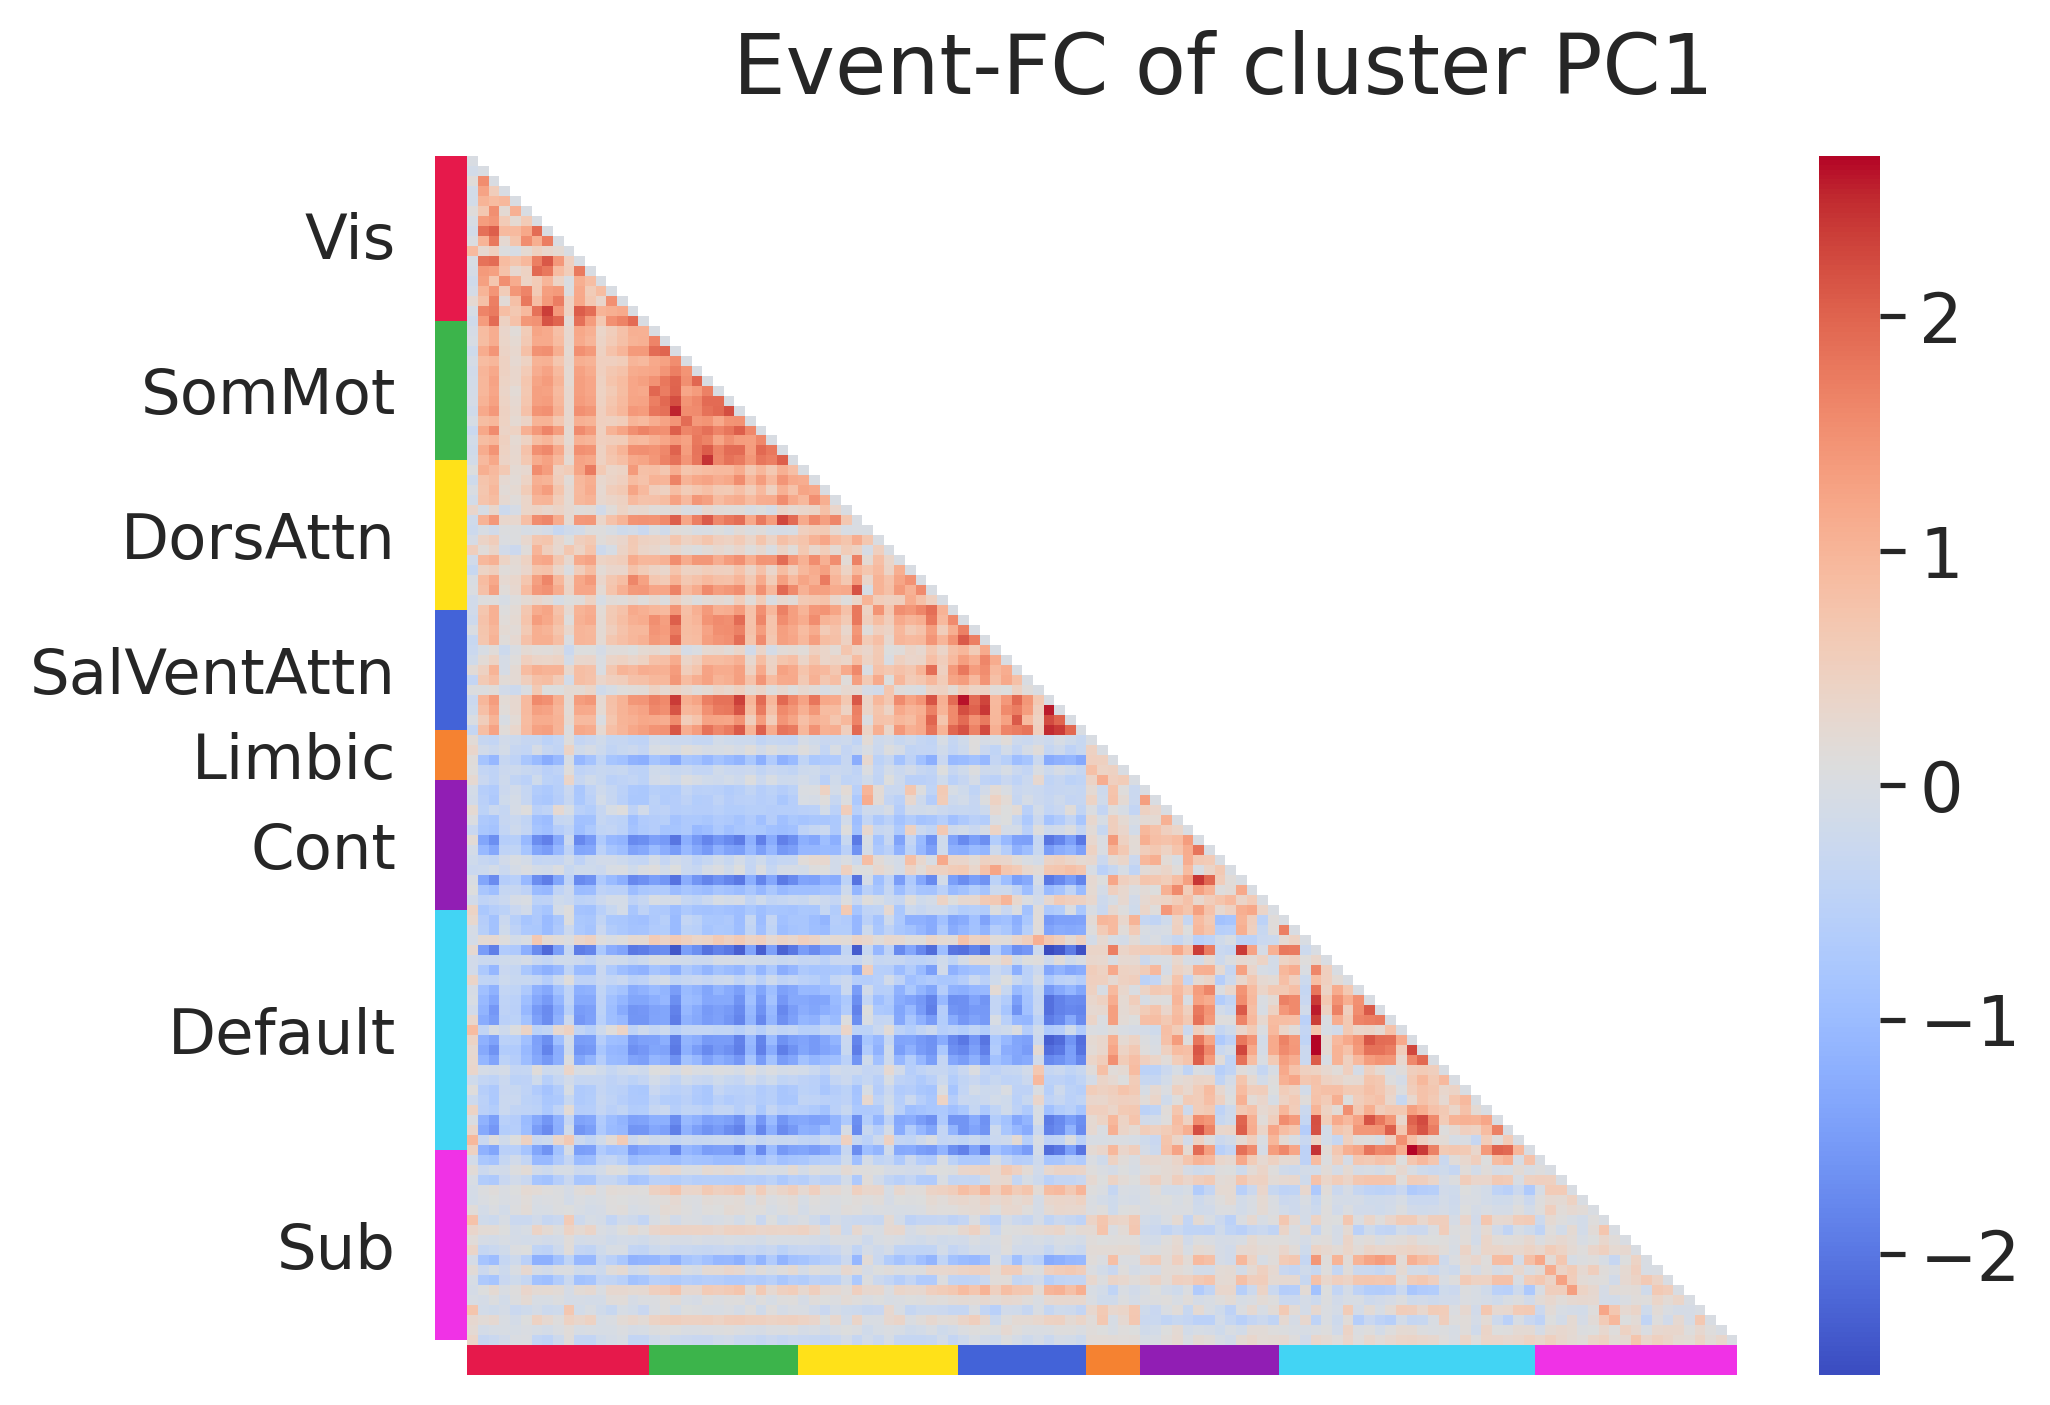

In [25]:
pattern = np.mean(all_fc[clusters==pattern_n],0)
plot_pattern(reconstruct_upper_matrix(pattern),title='Event-FC of cluster PC1')

### 前后差异

In [18]:
df = pd.DataFrame(clusters,index=all_fc.index,columns = ['pattern_i'])
df['sub_id'] = [i[:7] for i in df.index]
df['time'] = [i[8:] for i in df.index]

g = pd.DataFrame([])
x = fun_count_pattern_n(df,pattern_n,'baseline')
event_all = get_event_all('baseline')
x = pd.concat([x,event_all],axis=1);x = fun_add_demo_time(x,'baseline')
g = pd.concat([g,x])

for run_label in ['1st_201','1st_301','5th_201','5th_301','5th_after','4weeks']:
    y = fun_count_pattern_n(df,pattern_n,run_label)
    event_all = get_event_all(run_label)
    y = pd.concat([y,event_all],axis=1);y = fun_add_demo_time(y,run_label)
    g = pd.concat([g,y])
    z = fun_concat(x,y)
    model = smf.mixedlm("pattern_n ~ time + sex_id  + age", data=z, groups="sub_id")
    result = model.fit()
    t = result.tvalues[1];p = result.pvalues[1]
    print(f"sta={t:.3f},p={p:.3f} {run_label}")

g.to_csv(f"/data/dy/TIS_MDD/HAC/Cluster/frenquency/hierarchy_{schaefer}.csv",index=False)

sta=1.501,p=0.133 1st_201
sta=4.154,p=0.000 1st_301
sta=1.900,p=0.057 5th_201
sta=1.695,p=0.090 5th_301
sta=1.876,p=0.061 5th_after
sta=1.989,p=0.047 4weeks


         pattern_n  event_all sex   age   sub_id  sex_id      time
sub-033       12.0       23.0   M  59.0  sub-033       1  baseline
sub-015       19.0       25.0   M  29.0  sub-015       1  baseline
sub-036       22.0       35.0   M  49.0  sub-036       1  baseline


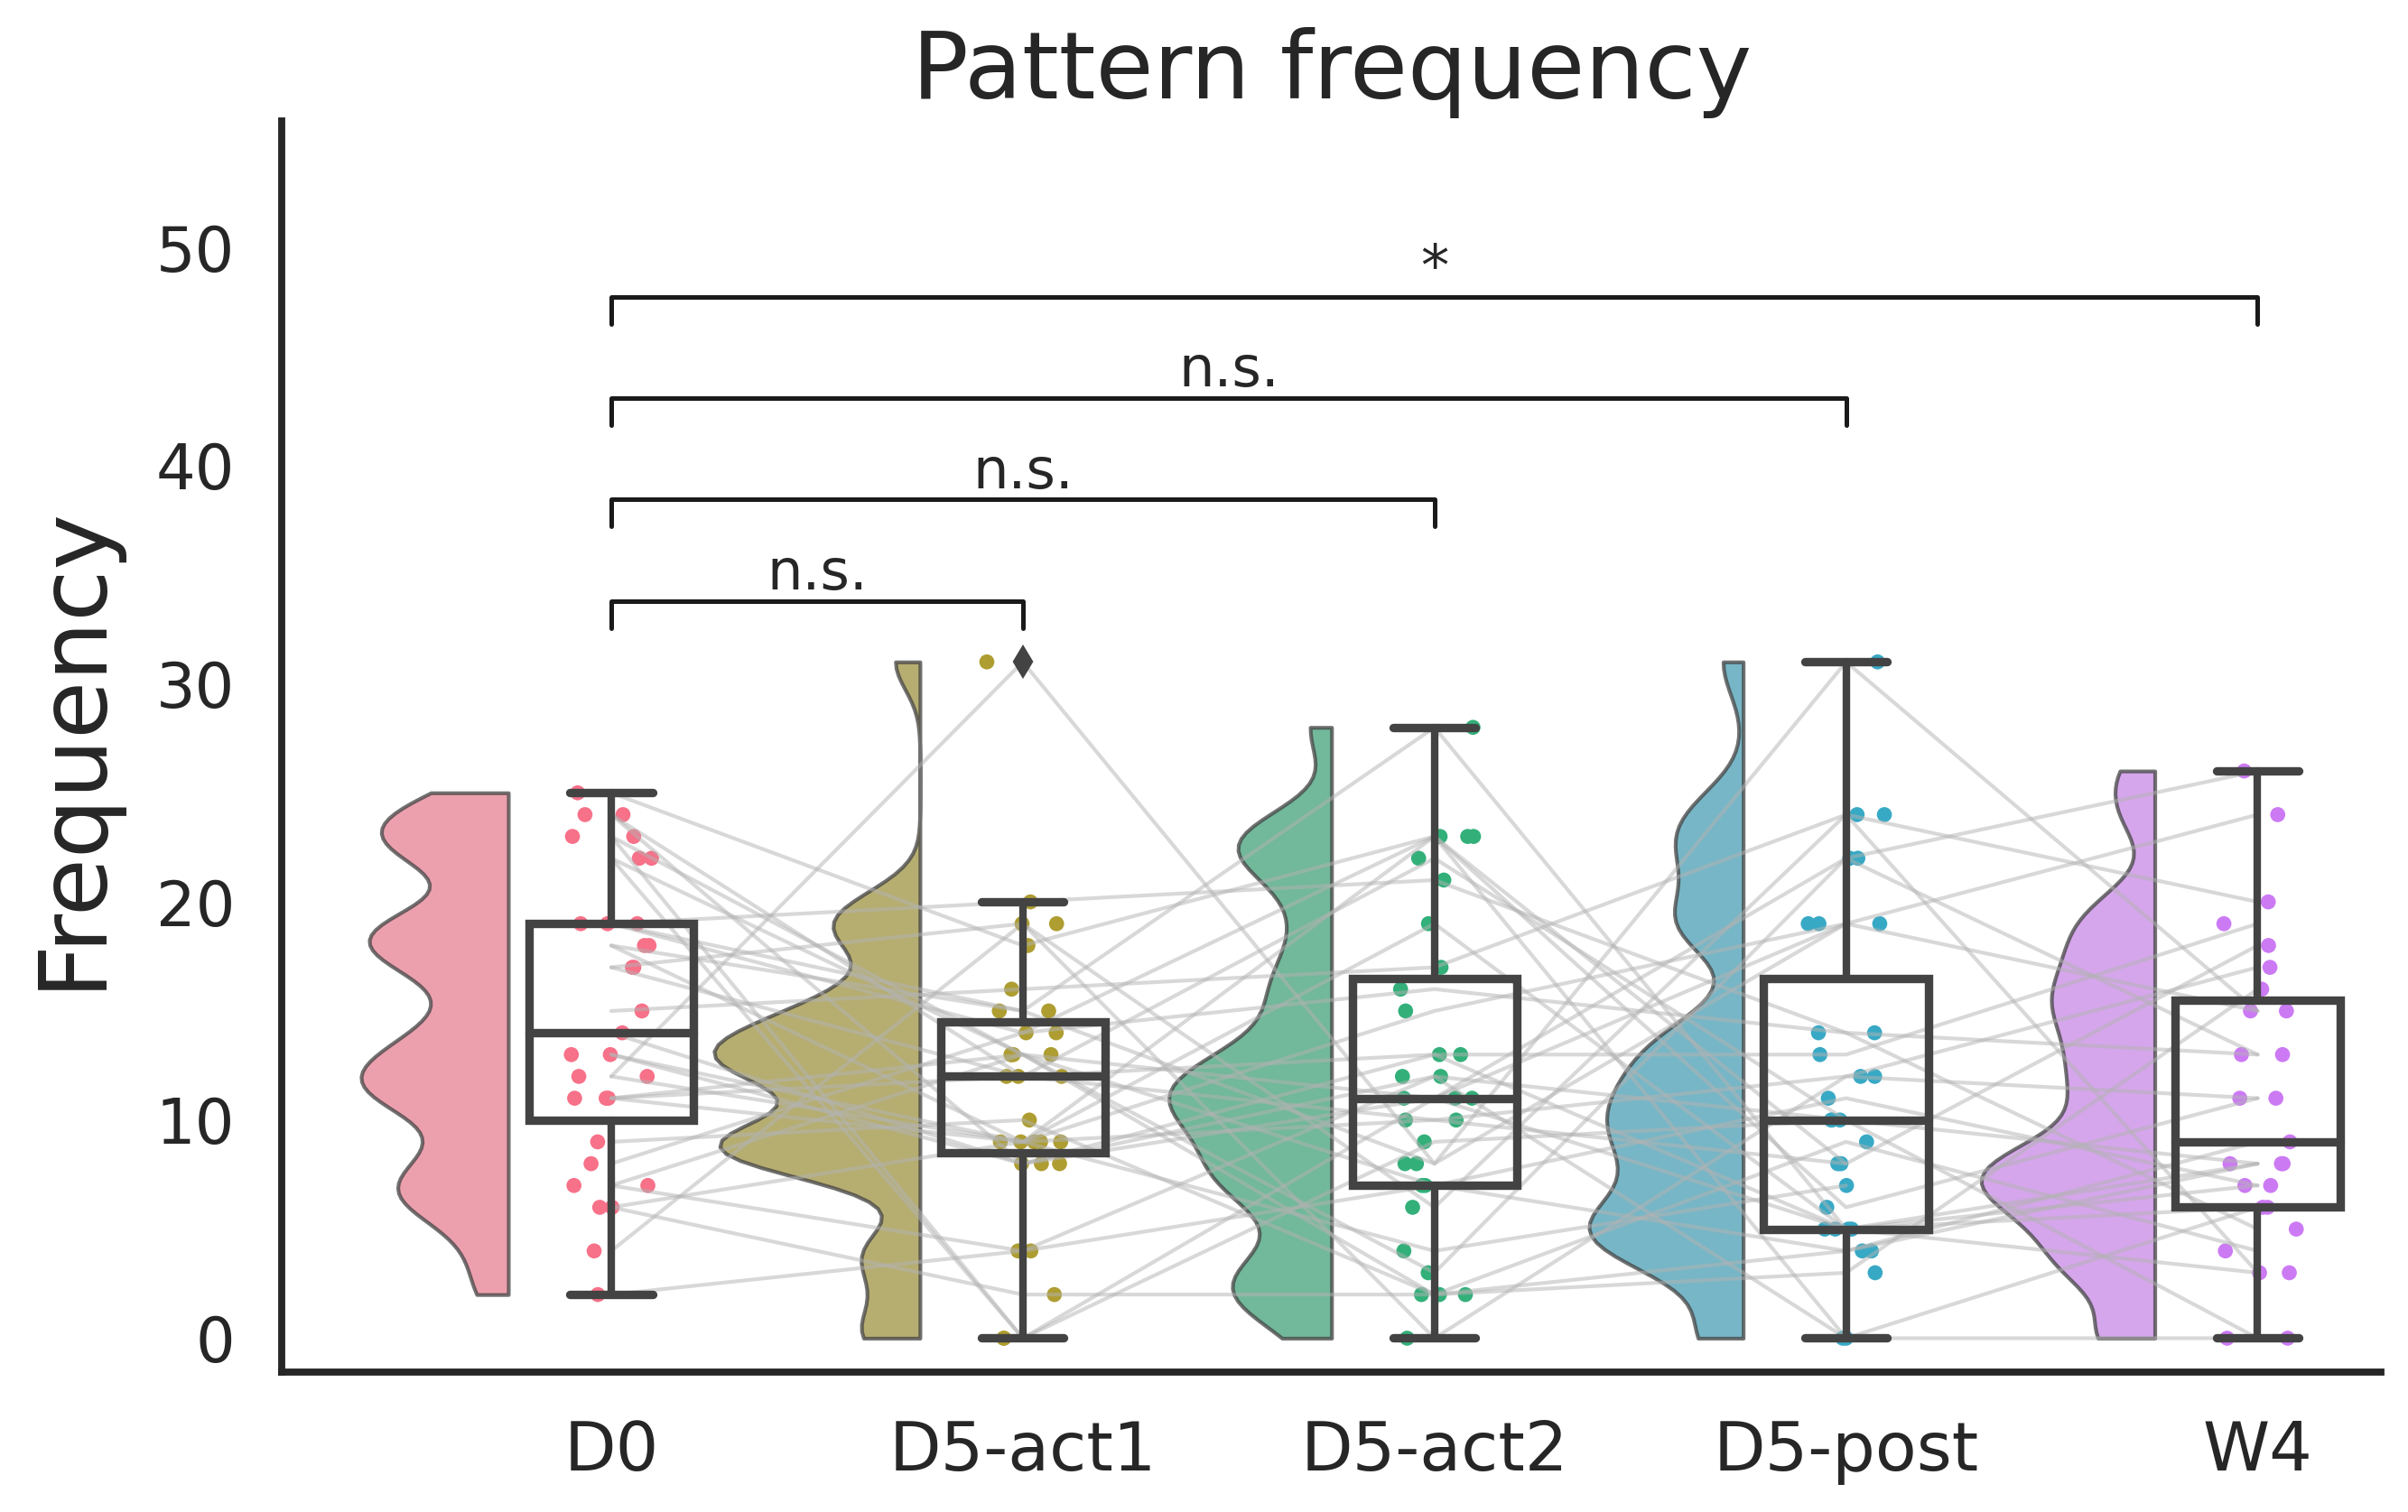

In [28]:
df = g.copy()
print(df.iloc[:3,:])
df = df.loc[:,['pattern_n','time','sub_id','event_all','sex_id','age']]
df.columns = ['pattern_n','condition','sub','event_all','sex_id','age']
df = df[df['condition']!='1st_201']
df = df[df['condition']!='1st_301']
longitudinal_plot(df,value_col='pattern_n',value_label = 'Frequency',
                  time_order = ['baseline','5th_201','5th_301','5th_after','4weeks'],
                  display_labels = ['D0','D5-act1','D5-act2','D5-post','W4'],
                  p_values = [],regress=True,regress_col=['age','sex_id'],
                  title='Pattern frequency')

### 量表相关性

---Timepoint:5th_after---
rou=-0.094, p=0.633, MADRS_all
rou=-0.307, p=0.112, GAD7_ALL
rou=-0.380, p=0.046, HAMA_all
rou=-0.183, p=0.343, HAMD_all
rou=-0.243, p=0.212, PHQ9_ALL
rou=-0.081, p=0.676, QIDS_all
---Timepoint:4weeks---
rou=0.268, p=0.195, MADRS_all
rou=0.203, p=0.341, GAD7_ALL
rou=0.285, p=0.167, HAMA_all
rou=0.414, p=0.039, HAMD_all
rou=-0.119, p=0.597, PHQ9_ALL
rou=0.445, p=0.026, QIDS_all
rou=0.373, p=0.067, PSQI_ALL
rou=-0.223, p=0.318, SF36_all
rou=0.293, p=0.155, SHAPS_all


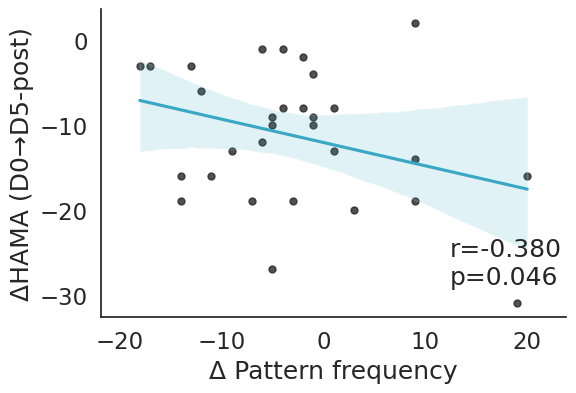

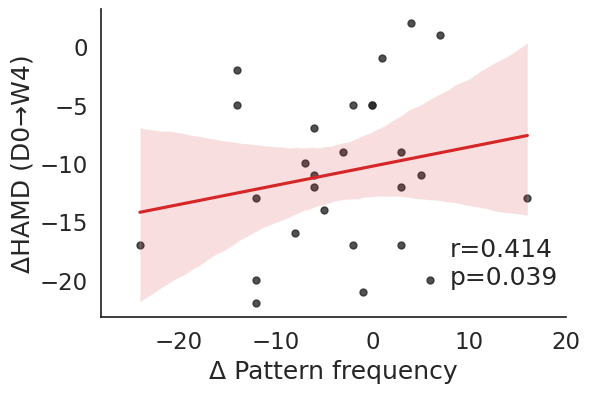

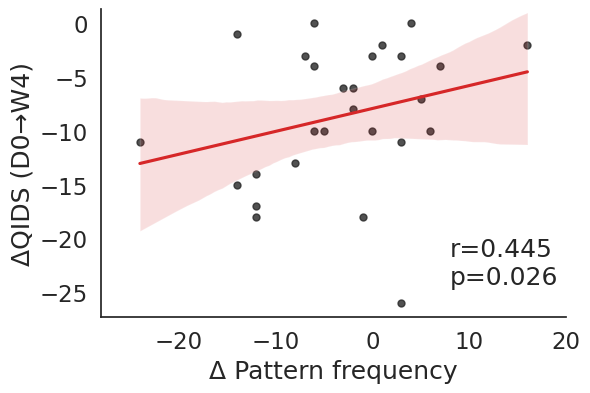

In [19]:
plot_correlation('5th')
plot_correlation('4week')

### responder 效应

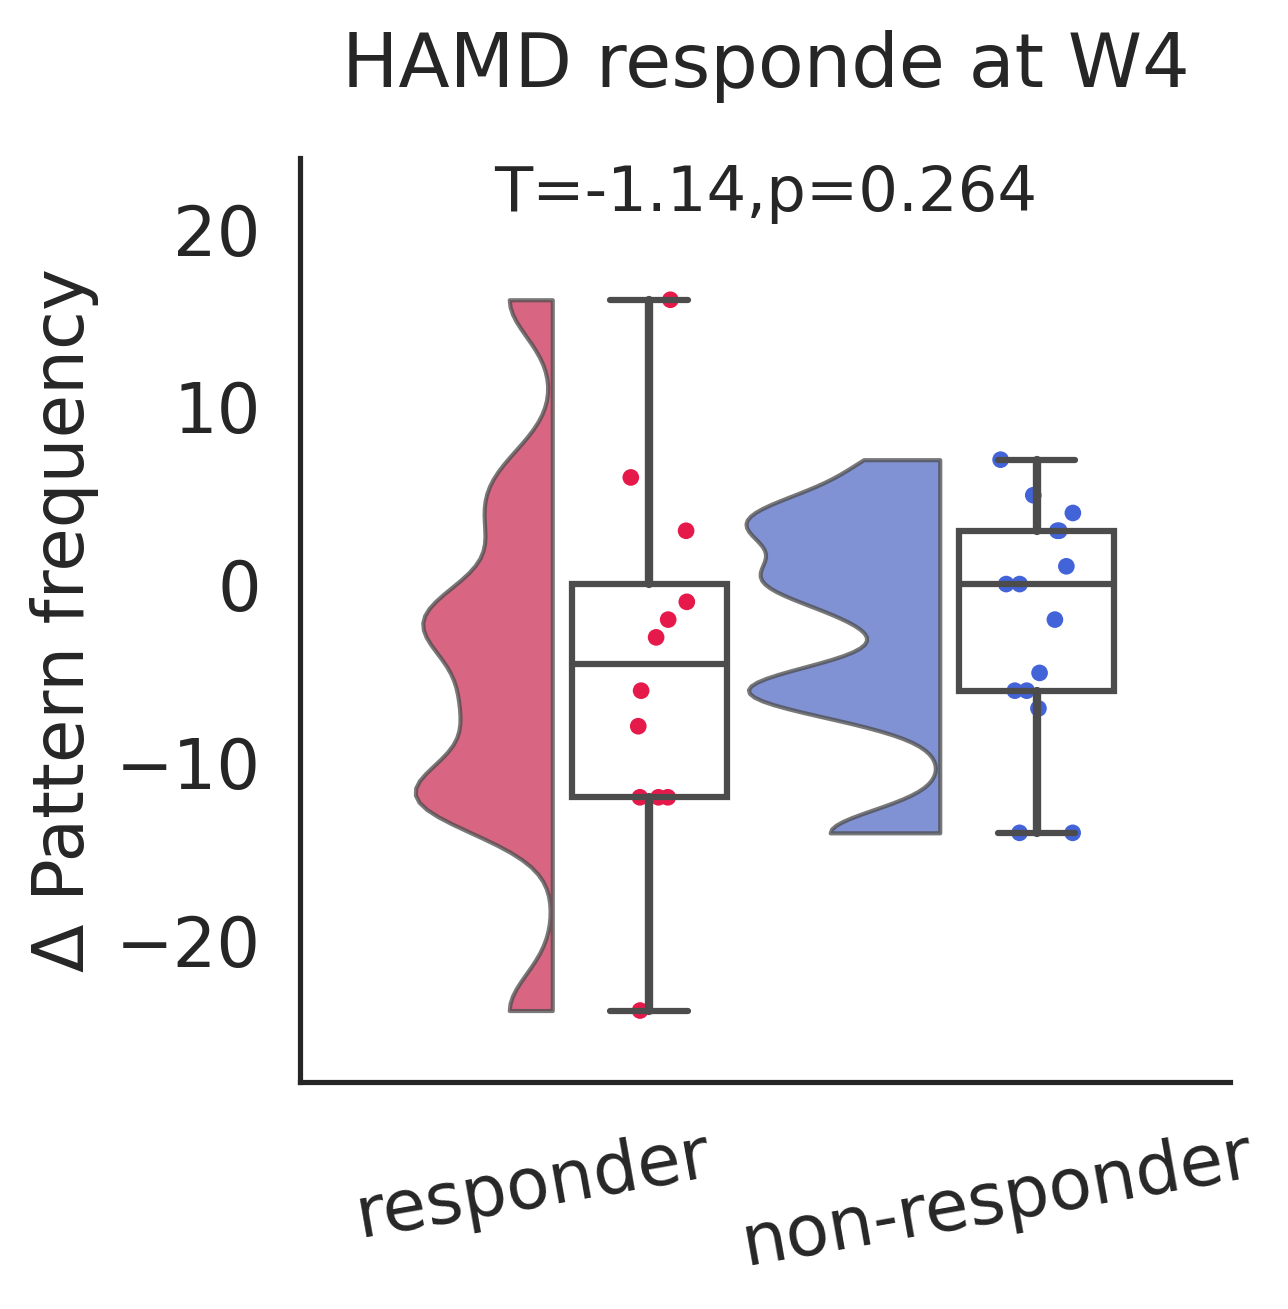

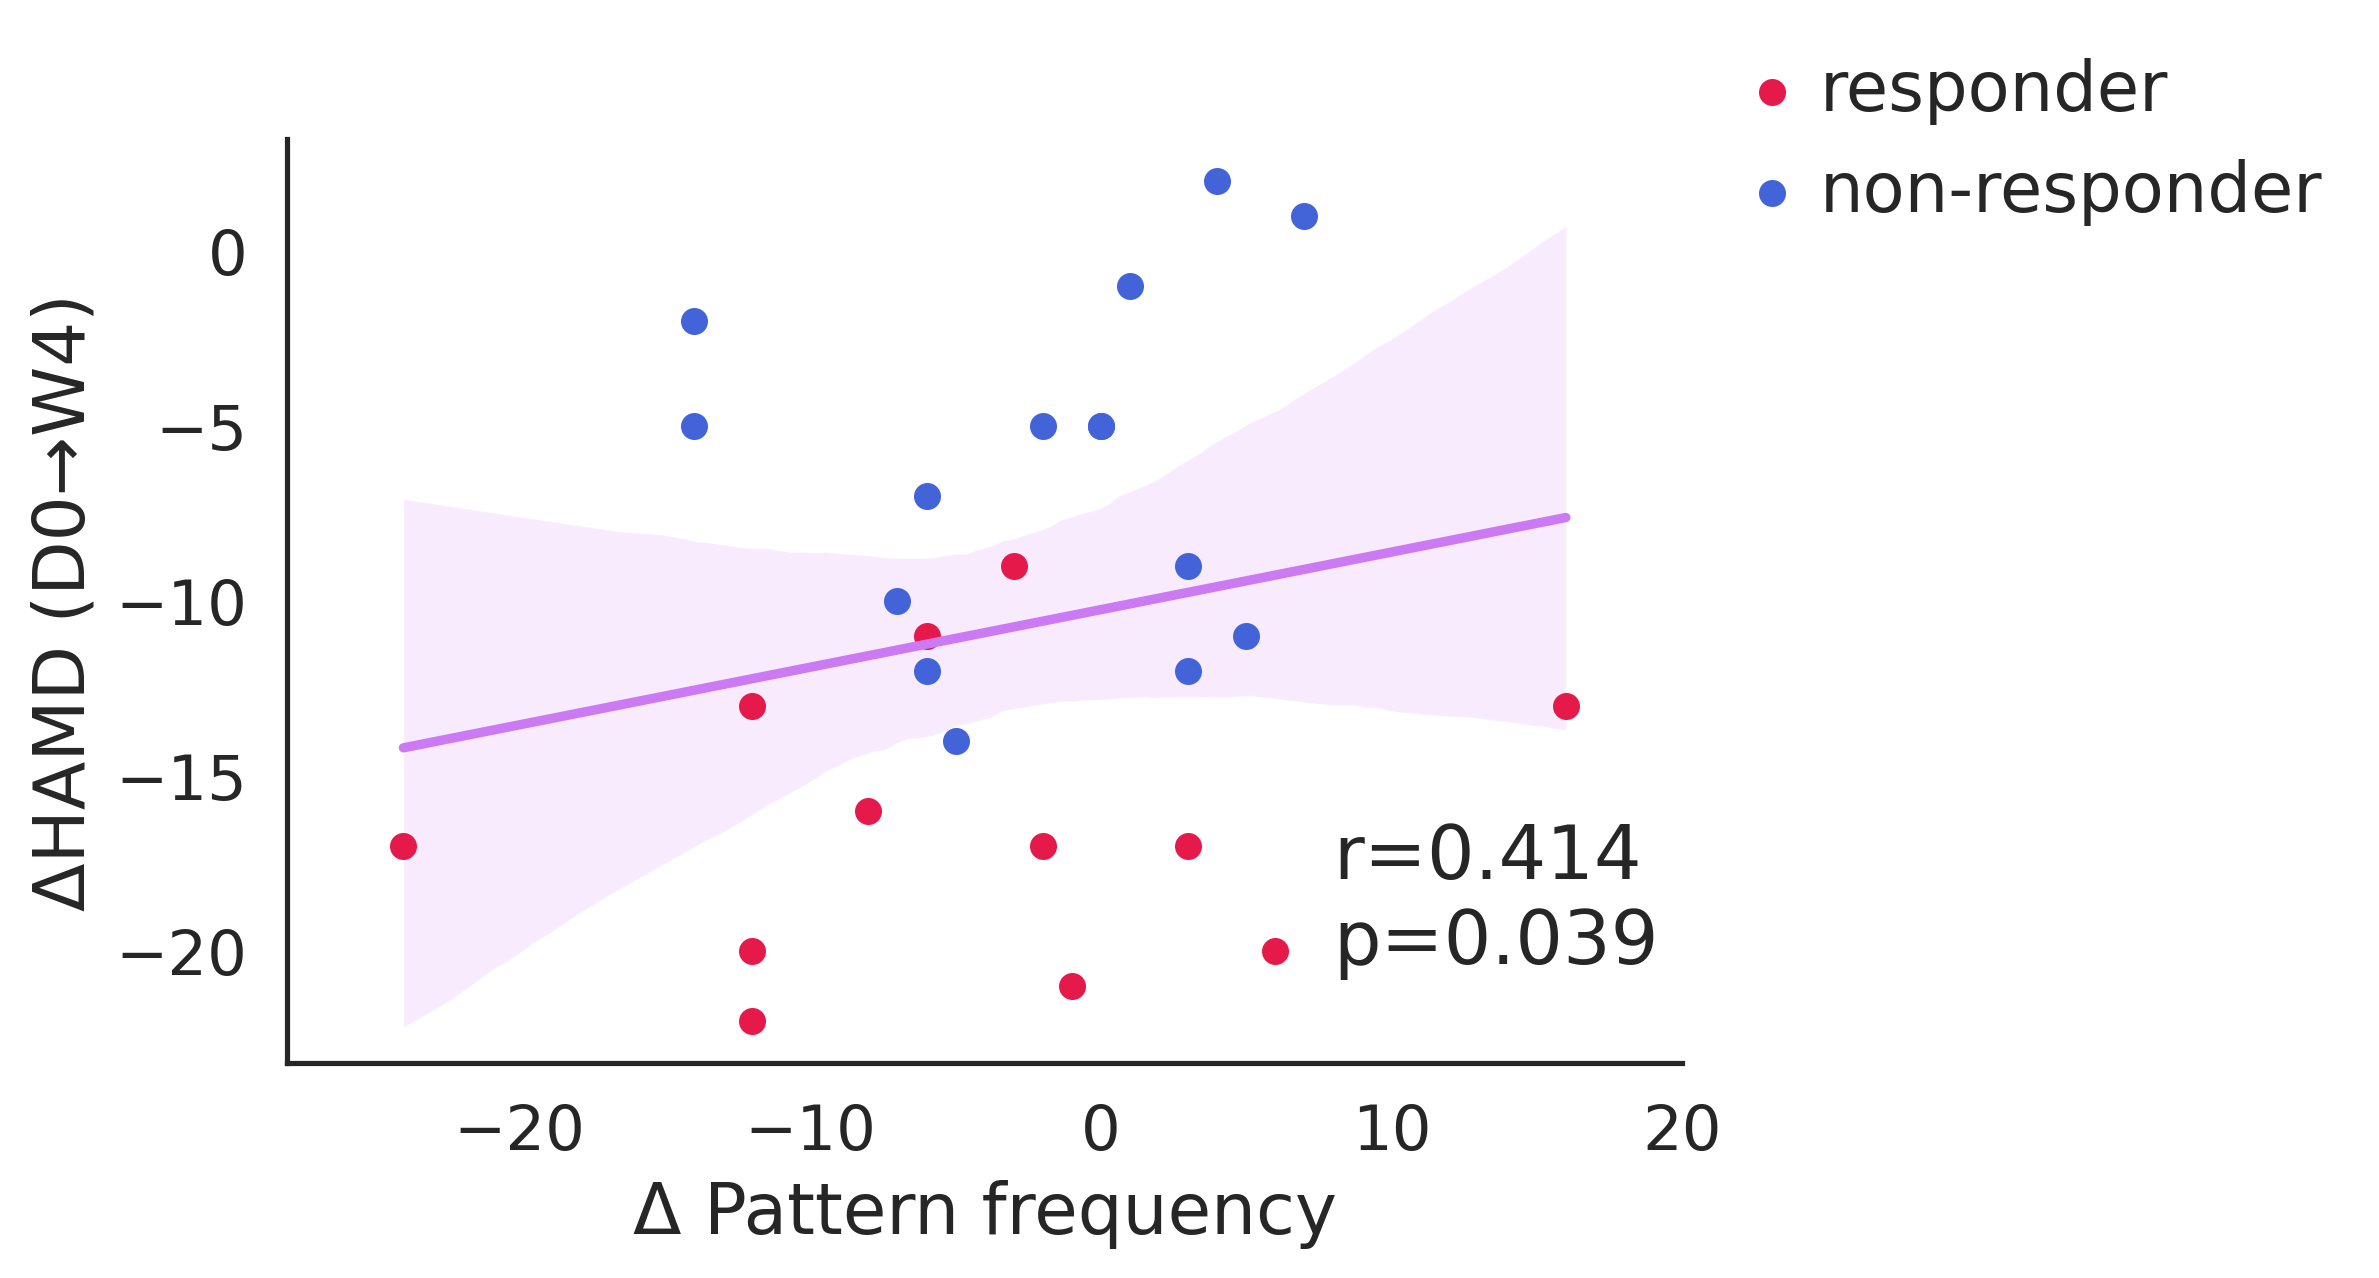

In [23]:
time_label = '4week'
scale = hamd.copy()
col_name = 'HAMD_all'
check_responde_effect(g,time_label,scale,col_name)

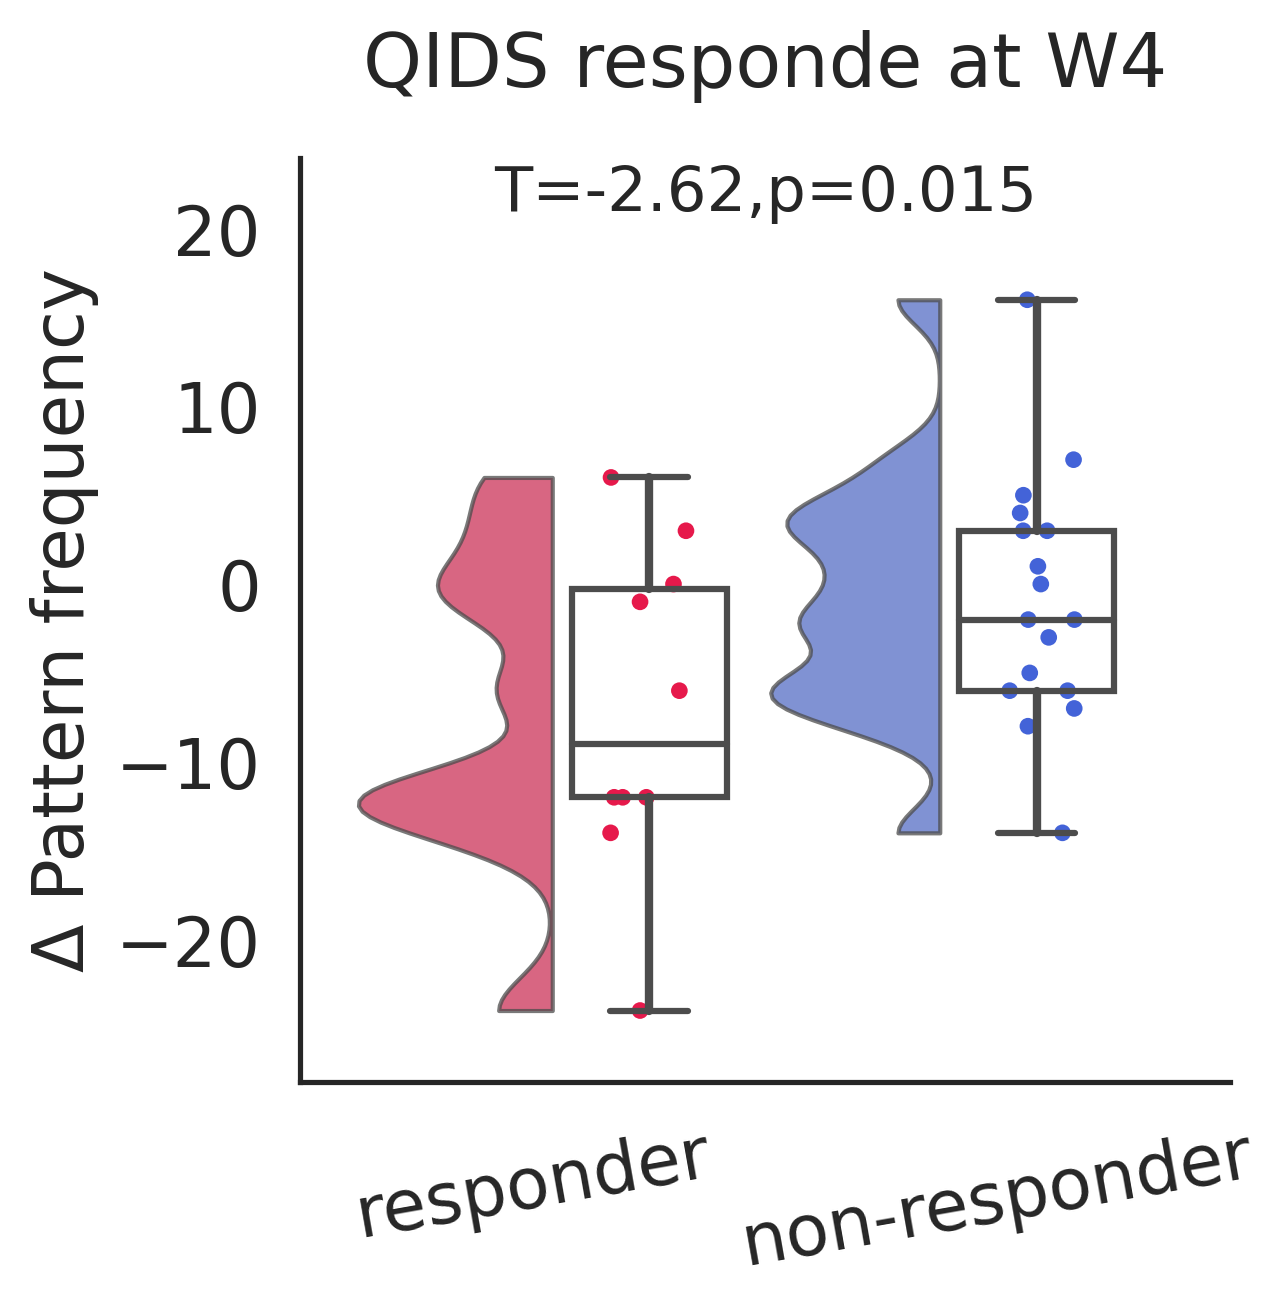

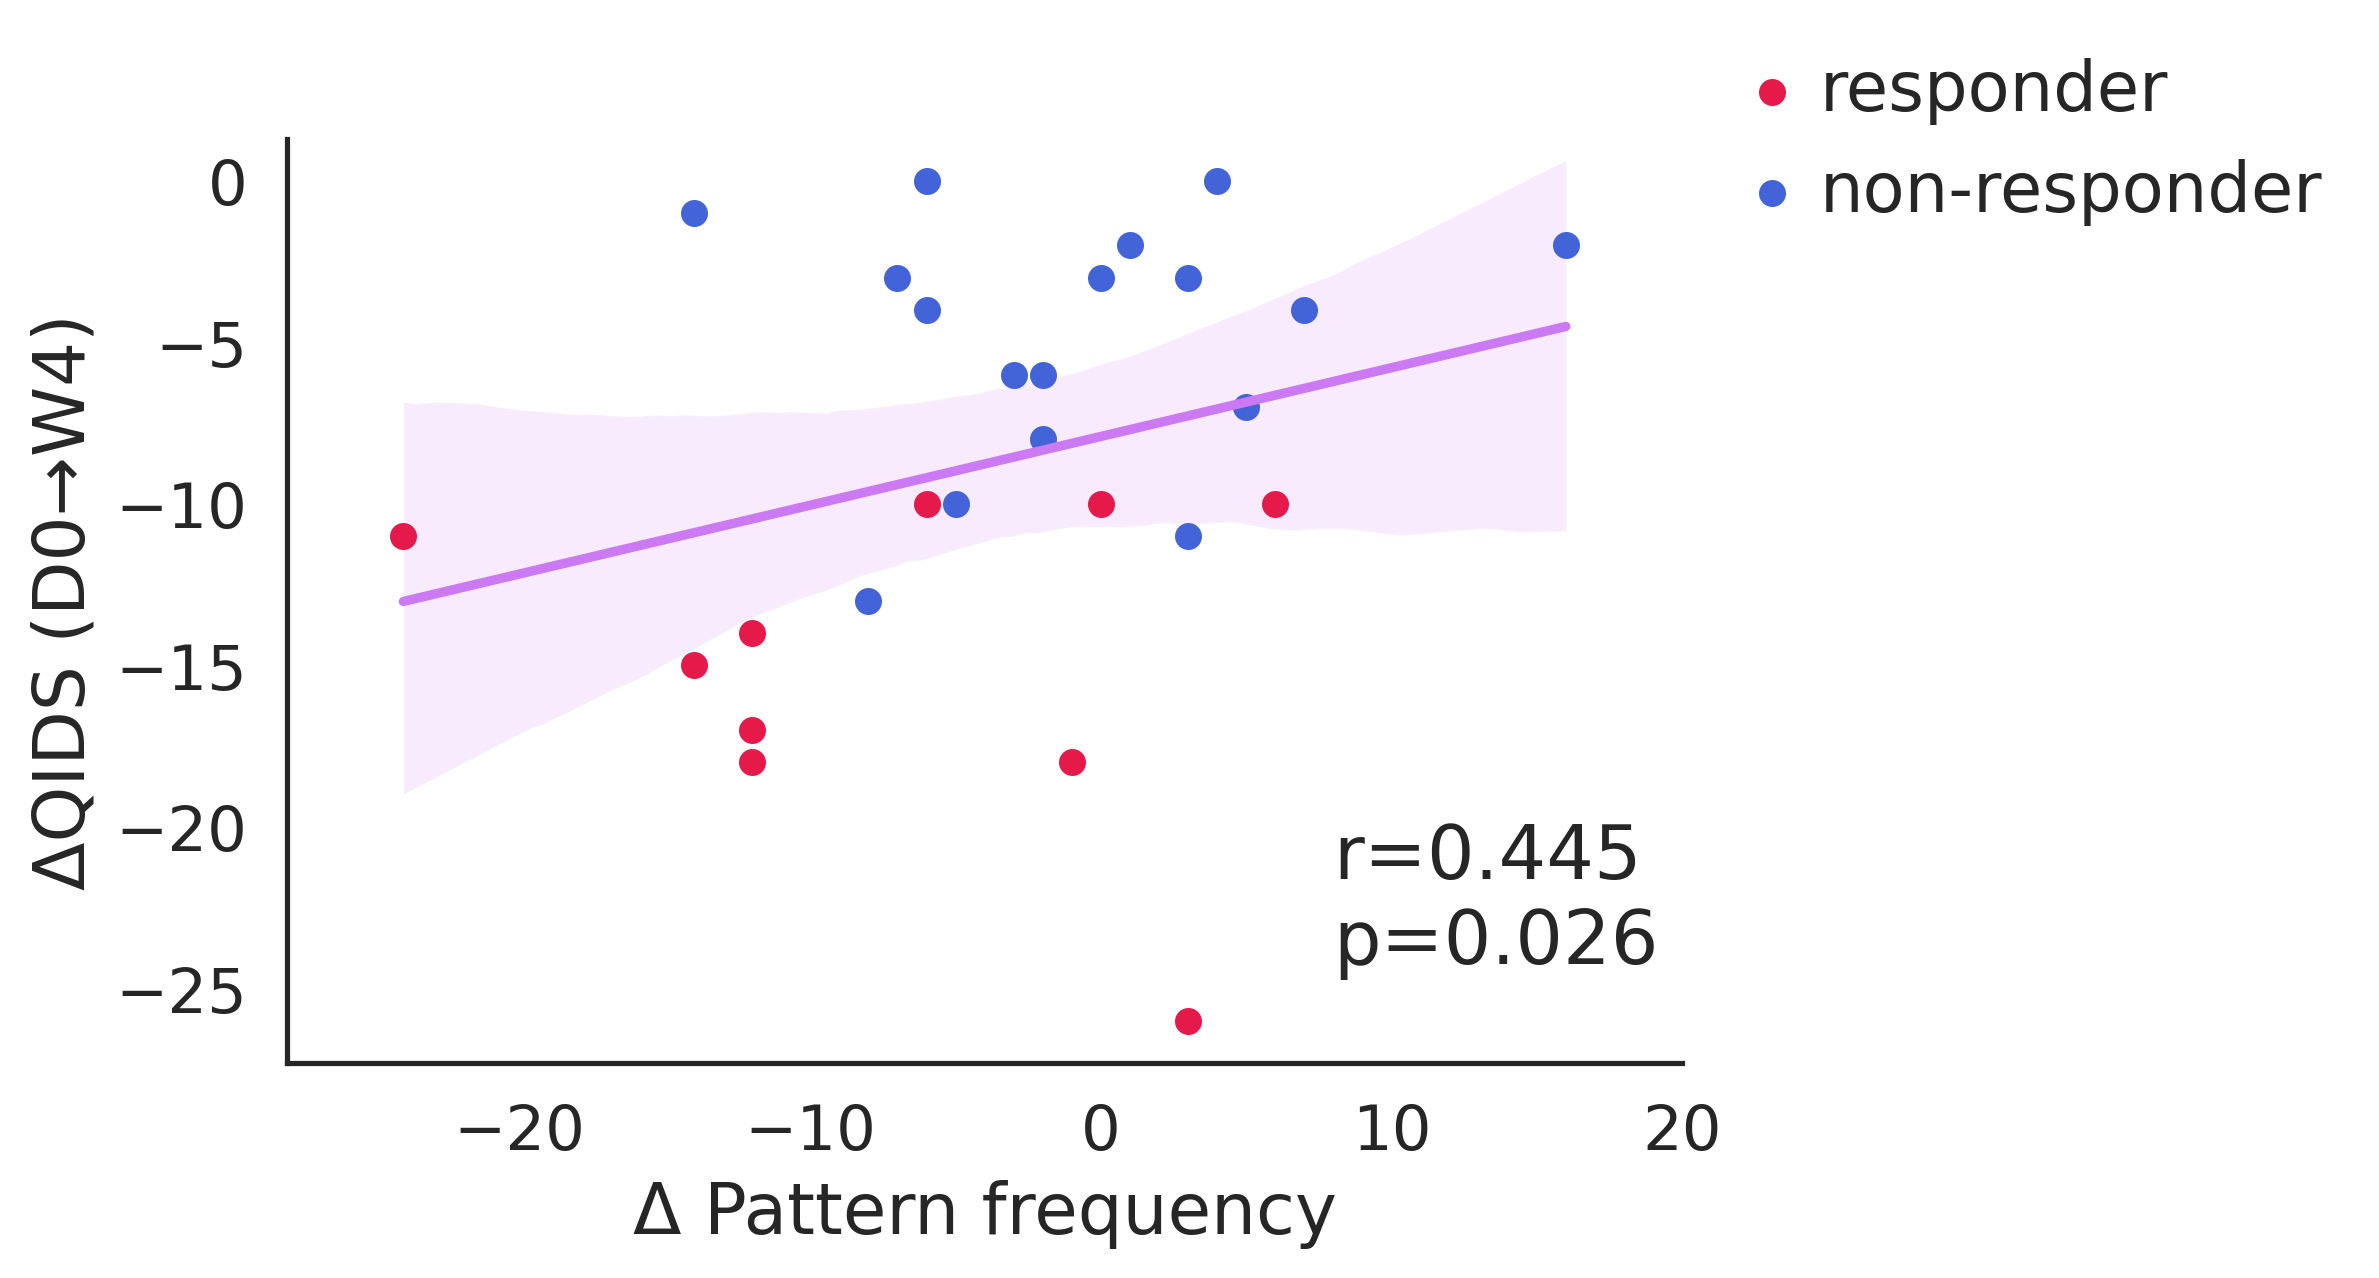

In [24]:
time_label = '4week'
scale = qids.copy()
col_name = 'QIDS_all'
check_responde_effect(g,time_label,scale,col_name)